In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, Activation, Rescaling
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import itertools

tf.__version__

'2.14.0'

In [3]:
# Loading dataset with labels and metadata from tensorflow_datasets online
(our_train_dataset, our_test_dataset), dataset_info = tfds.load('cifar10', split = ['train', 'test'], 
                                                                data_dir = 'content/Cifar10/', shuffle_files = True, 
                                                                as_supervised = True, with_info = True)

assert isinstance(our_train_dataset, tf.data.Dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling content\Cifar10\cifar10\3.0.2.incompleteHSVIVT\cifar10-train.tfrecord*...:   0%|          | 0/50000 …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling content\Cifar10\cifar10\3.0.2.incompleteHSVIVT\cifar10-test.tfrecord*...:   0%|          | 0/10000 […

Dataset cifar10 downloaded and prepared to content/Cifar10/cifar10\3.0.2. Subsequent calls will reuse this data.


In [4]:
# Display some info about the dataset
image_shape = dataset_info.features["image"].shape
print(f'Shape of Images in the Dataset: \t{image_shape}')

num_classes = dataset_info.features["label"].num_classes
print(f'Number of Classes in the Dataset: \t{num_classes}')

names_of_classes = dataset_info.features["label"].names
print(f'Names of Classes in the Dataset: \t{names_of_classes}\n')

for name in names_of_classes:
    print(f'Label for class "{name}": \t\t{dataset_info.features["label"].str2int(name)}')

print(f'Total examples in Train Dataset: \t{len(our_train_dataset)}')
print(f'Total examples in Test Dataset: \t{len(our_test_dataset)}')

Shape of Images in the Dataset: 	(32, 32, 3)
Number of Classes in the Dataset: 	10
Names of Classes in the Dataset: 	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label for class "airplane": 		0
Label for class "automobile": 		1
Label for class "bird": 		2
Label for class "cat": 		3
Label for class "deer": 		4
Label for class "dog": 		5
Label for class "frog": 		6
Label for class "horse": 		7
Label for class "ship": 		8
Label for class "truck": 		9
Total examples in Train Dataset: 	50000
Total examples in Test Dataset: 	10000


In [5]:
# Prepare the datasets similarly to the previous exercise - Normalise 0-255 colour vals to 0-1, then cache and load a batch to train and test the model with - note that the batch for the training set is randomised
tf.random.set_seed(8)

normalization_layer = Rescaling(1./255)

our_train_dataset = our_train_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls = tf.data.experimental.AUTOTUNE)
our_train_dataset = our_train_dataset.cache()
our_train_dataset = our_train_dataset.shuffle(len(our_train_dataset))
our_train_dataset = our_train_dataset.batch(128)
our_train_dataset = our_train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

our_test_dataset = our_test_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls = tf.data.experimental.AUTOTUNE)
our_test_dataset = our_test_dataset.cache()
our_test_dataset = our_test_dataset.batch(1024)
our_test_dataset = our_test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
# Building a model using the functional API - calling the previously built layer(s) to make a set of layers, then using that to input to `Model` to build the full model
# I personally prefer the look of adding the layers to a specified `Sequential` model over this - the explicit nature of the previous code makes it much easier to read.
input_layer = Input(shape=image_shape)

x = Conv2D(filters = 32, kernel_size = (3, 3), strides=2)(input_layer)
x = Activation('relu')(x)

x = Conv2D(filters = 64, kernel_size = (3, 3), strides=2)(x)
x = Activation('relu')(x)

x = Conv2D(filters = 128, kernel_size = (3, 3), strides=2)(x)
x = Activation('relu')(x)

x = Flatten()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(units = 1024)(x)
x = Activation('relu')(x)
x = Dropout(rate = 0.2)(x)

x = Dense(units = num_classes)(x)

output = Activation('softmax')(x)

our_classification_model = Model(input_layer, output)

In [7]:
# Build and train the model - note that training time will be long if on CPU.
our_classification_model.compile(
                      optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'], loss_weights=None,
                      weighted_metrics=None, run_eagerly=None,
                      steps_per_execution=None
)

print(our_classification_model.summary())

history = our_classification_model.fit(our_train_dataset, validation_data=our_test_dataset, epochs=15)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 32)        896       
                                                                 
 activation (Activation)     (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 activation_1 (Activation)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 activation_2 (Activation)   (None, 3, 3, 128)         0     

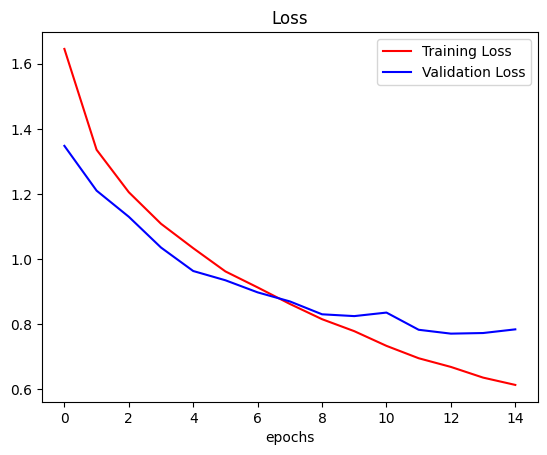

<Figure size 640x480 with 0 Axes>

In [8]:
# Generating a graph that shows the loss per epoch, by building a function that can generally show a trend on a graph
def plot_trend_by_epoch(tr_values, val_values, title):
    epoch_number = range(len(tr_values))
    plt.plot(epoch_number, tr_values, 'r')
    plt.plot(epoch_number, val_values, 'b')
    plt.title(title)
    plt.xlabel('epochs')
    plt.legend(['Training '+title, 'Validation '+title])
    plt.figure()

hist_dict = history.history
tr_loss, val_loss = hist_dict['loss'], hist_dict['val_loss']
plot_trend_by_epoch(tr_loss, val_loss, "Loss")

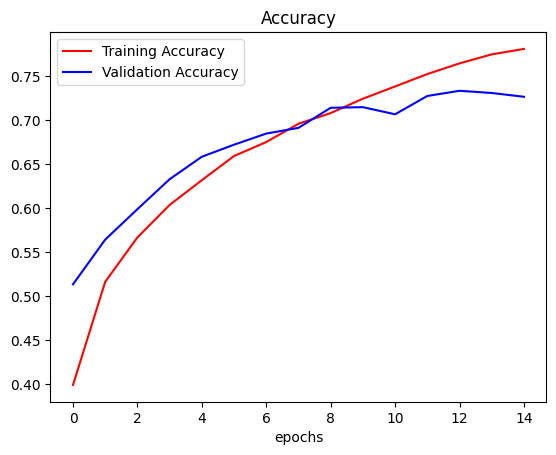

<Figure size 640x480 with 0 Axes>

In [9]:
# Reuse plotting function for model accuracy
tr_accuracy, val_accuracy = hist_dict['accuracy'], hist_dict['val_accuracy']
plot_trend_by_epoch(tr_accuracy, val_accuracy, "Accuracy")

10/10 [==============================] - 1s 53ms/step


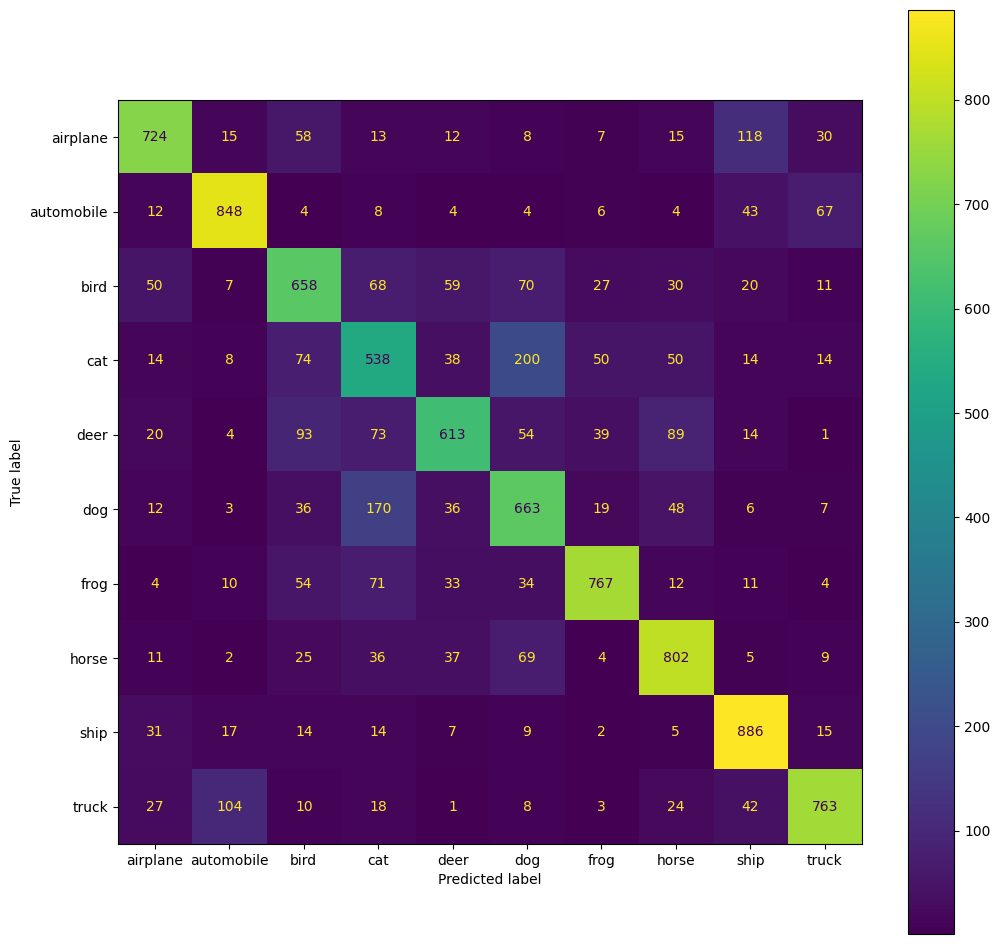

In [10]:
# Plotting a confusion matrix for the test dataset predictions
test_labels = []
test_images = []

for image, label in tfds.as_numpy(our_test_dataset.unbatch()):
    test_images.append(image)
    test_labels.append(label)

test_labels = np.array(test_labels)
predictions = our_classification_model.predict(our_test_dataset).argmax(axis=1)
conf_matrix = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels = names_of_classes)

fig = plt.figure(figsize = (12, 12))
axis = fig.add_subplot(111)
disp.plot(values_format = 'd', ax = axis)

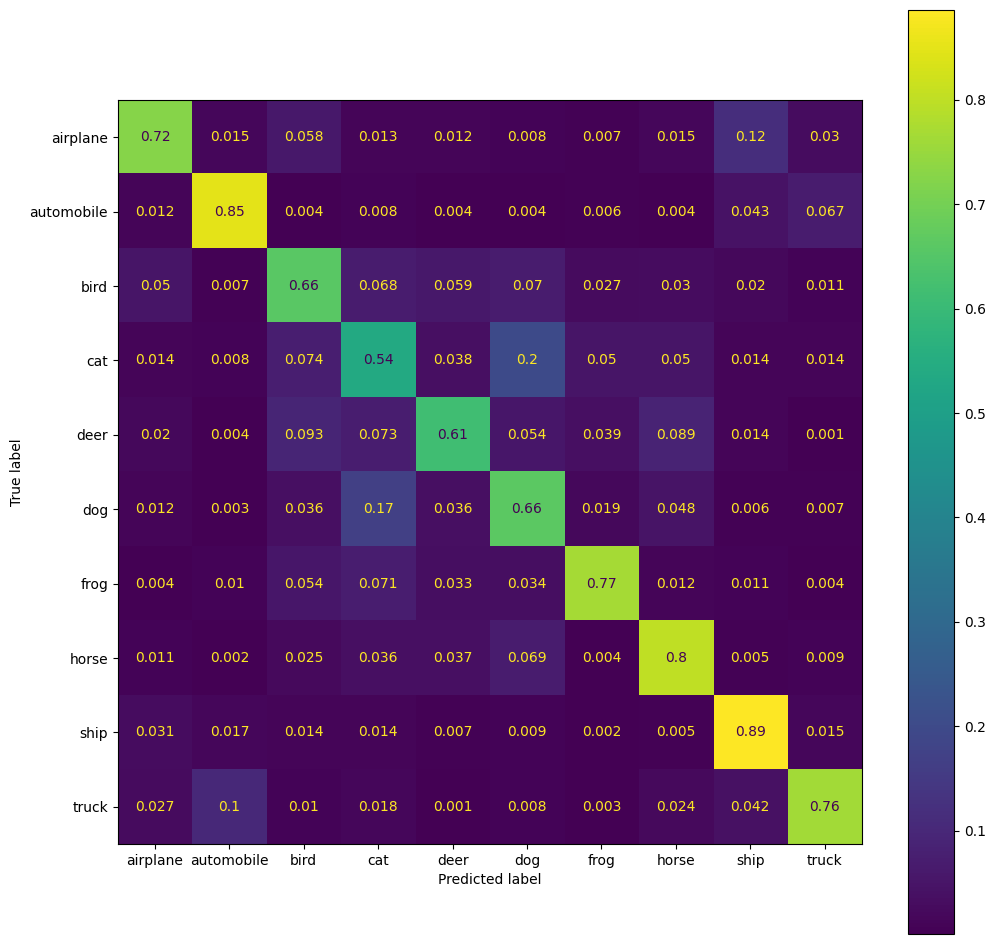

In [11]:
# Plot another confusion matrix, this time with normalisation
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1) [:, np.newaxis]
disp = ConfusionMatrixDisplay(conf_matrix, display_labels = names_of_classes)

fig = plt.figure(figsize = (12, 12))
axis = fig.add_subplot(111)
disp.plot(ax = axis)

True label: cat
Predicted label: bird


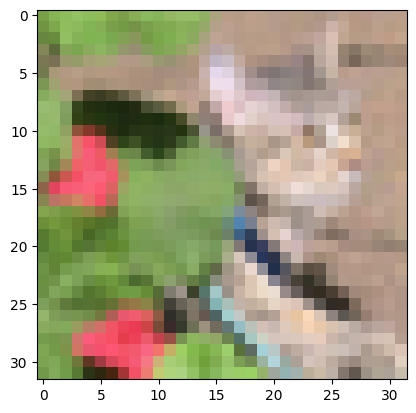

In [12]:
# Get the first incorrect prediction, and display the image along with the predicted and actual label
incorrect_predictions = np.where(predictions != test_labels)[0]

index = np.random.choice(incorrect_predictions)
plt.imshow(test_images[index])

print(f'True label: {names_of_classes[test_labels[index]]}')
print(f'Predicted label: {names_of_classes[predictions[index]]}')